# Data Analysis: YNAB Support Forums
- Sita Thomas
- NYCDSA Web Scraping Project
- July 2020
- Project Github repository: https://github.com/sitathomas/web_scraping_project
- Project Insights presentation: https://docs.google.com/presentation/d/1y5IqYeUl8clRyYfJsZpdicWZIrdRsMSm4ux8Dt0Ands

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Scraped-Data-Import" data-toc-modified-id="Scraped-Data-Import-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scraped Data Import</a></span></li><li><span><a href="#User-Stats" data-toc-modified-id="User-Stats-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><strong>User Stats</strong></a></span></li><li><span><a href="#Interaction-Stats" data-toc-modified-id="Interaction-Stats-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Interaction Stats</a></span></li><li><span><a href="#User-Lifespan" data-toc-modified-id="User-Lifespan-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>User Lifespan</a></span></li><li><span><a href="#User-Lifespan-Graphs" data-toc-modified-id="User-Lifespan-Graphs-6"><span class="toc-item-num">6&nbsp;&nbsp;</span><strong>User Lifespan Graphs</strong></a></span></li><li><span><a href="#Topic-Categories" data-toc-modified-id="Topic-Categories-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Topic Categories</a></span></li><li><span><a href="#Topic-Category-Graphs" data-toc-modified-id="Topic-Category-Graphs-8"><span class="toc-item-num">8&nbsp;&nbsp;</span><strong>Topic Category Graphs</strong></a></span></li><li><span><a href="#Topic-Category-Z-Scores" data-toc-modified-id="Topic-Category-Z-Scores-9"><span class="toc-item-num">9&nbsp;&nbsp;</span><strong>Topic Category Z-Scores</strong></a></span></li><li><span><a href="#Top-Stats" data-toc-modified-id="Top-Stats-10"><span class="toc-item-num">10&nbsp;&nbsp;</span><strong>Top Stats</strong></a></span></li><li><span><a href="#Sentiment-Analysis" data-toc-modified-id="Sentiment-Analysis-11"><span class="toc-item-num">11&nbsp;&nbsp;</span><strong>Sentiment Analysis</strong></a></span></li><li><span><a href="#NLP-Pre-Processing" data-toc-modified-id="NLP-Pre-Processing-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>NLP Pre-Processing</a></span></li><li><span><a href="#N-grams-Function" data-toc-modified-id="N-grams-Function-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>N-grams Function</a></span></li><li><span><a href="#Text-Bigrams-Word-Cloud" data-toc-modified-id="Text-Bigrams-Word-Cloud-14"><span class="toc-item-num">14&nbsp;&nbsp;</span><strong>Text Bigrams Word Cloud</strong></a></span></li><li><span><a href="#Time-Series" data-toc-modified-id="Time-Series-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>Time Series</a></span></li><li><span><a href="#Bigram-WC-for-April-2020" data-toc-modified-id="Bigram-WC-for-April-2020-16"><span class="toc-item-num">16&nbsp;&nbsp;</span>Bigram WC for April 2020</a></span></li></ul></div>

## Setup

In [25]:
import copy
from scipy import stats
from sklearn.linear_model import LinearRegression
import re
from textblob import TextBlob, Word
from wordcloud import WordCloud

import pandas as pd
pd.set_option('display.max_columns', None)

import datetime
from datetime import date, timedelta

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.graph_objs import Figure
from plotly.subplots import make_subplots
plotly.offline.init_notebook_mode(connected=True)

import os
if not os.path.exists("images"):
    os.mkdir("images")

## Scraped Data Import

In [26]:
ynab_raw = pd.read_csv("ynab/ynab.csv")
ynab_raw.following = ynab_raw.following.apply(lambda x: int(x))
ynab_raw.posted = pd.to_datetime(ynab_raw.posted)

ynab = copy.deepcopy(ynab_raw)
ynab["date"] = ynab.posted.dt.date
ynab["month"] = ynab.posted.dt.to_period("M")
ynab.month = ynab.month.apply(lambda x: x.astype('datetime64[ns]'))
ynab = ynab[["category", "title", "text", "user", "likes", "replies", "views",
                "following", "posted", "date", "month"]]
ynab.sample(5)[["category", "title", "text", "user", "likes", "replies", "views",
                "following", "posted"]]

,category,title,text,user,likes,replies,views,following,posted
1931,App Functions,"Negative ""to be budgeted"" every month?",I spend what I budget. At the end of each mont...,Beige_Cartridge.4,0,44,458,12,2020-01-25 05:16:00
7095,Community Challenges,2019: Pay Down the Mortgage Challenge,Welcome to the 2019 Pay Down The Mortgage Chal...,HappyDance,0,0,162,1,2019-02-06 01:09:00
3278,Credit Cards,Credit card overspending category (no judgment...,We intentionally put a purchase on a credit ca...,staceychev,0,10,85,5,2019-09-05 04:17:00
3972,Tips & Tricks,Uncatergorized Transaction,Have you ever had an uncatergorized Transactio...,Aquamarine_Boa.7,0,2,78,4,2019-06-20 01:29:00
1068,Investing & Retirement,Podcast Correction,I'm sorry if this has already been posted some...,suninmoon,1,25,358,10,2019-07-29 09:02:00


## **User Stats**

In [27]:
posts_by_user = pd.DataFrame(ynab.groupby("user").size()).sort_values(0, ascending=False).reset_index()
posts_by_user.columns = ["user", "posts"]
posts_by_user["ratio"] = round(posts_by_user["posts"] / len(ynab), 3)

post_count = len(ynab)
unique_user_count = len(set(ynab.user))
print("Number of posts:", post_count)
print("Number of unique users:", unique_user_count)
print("Ratio of unique users:", round(unique_user_count / post_count, 2))
print("Top 5 Users:", "\n", posts_by_user[:5])

Number of posts: 7142
Number of unique users: 4629
Ratio of unique users: 0.65
Top 5 Users: 
                       user  posts  ratio
0            Khaki_Storm.1     64  0.009
1                    MXMOM     44  0.006
2  Tomato_Mask_05bd62cee89     42  0.006
3           Maroon_Admiral     29  0.004
4            Green_Nomad.7     26  0.004


## Interaction Stats

In [28]:
print("Average posts per user:", round(len(ynab) / len(set(ynab.user)), 2))
def avg_stats(field):
  print("Average {}:".format(field), round(ynab.sort_values(field, ascending=False)[field].mean(), 2))
avg_stats("likes")
avg_stats("replies")
avg_stats("views")
avg_stats("following")
print()
def median_stats(field):
  print("Median {}:".format(field), round(ynab.sort_values(field, ascending=False)[field].median(), 2))
median_stats("likes")
median_stats("replies")
median_stats("views")
median_stats("following")

Average posts per user: 1.54
Average likes: 0.88
Average replies: 8.83
Average views: 529.22
Average following: 5.08

Median likes: 0.0
Median replies: 5.0
Median views: 217.0
Median following: 4.0


## User Lifespan

In [29]:
# All user lifespans
lifespan = ynab.groupby(["user"], as_index=False).agg({"date": ["min", "max"]})
lifespan.columns = lifespan.columns.to_flat_index()
lifespan.columns = ["user", "first_post", "last_post"]
lifespan["duration"] = (lifespan.last_post - lifespan.first_post).dt.days // 30.4 # duration in months
lifespan = pd.merge(lifespan, posts_by_user[["user", "posts"]], on="user")
lifespan_graph = px.scatter(lifespan.groupby("duration").count().reset_index(),
                            x="duration", y="user", size="user", size_max=40, title="User Lifespan in Months")

# Users who have posted within the last 2 months
active_users = lifespan.loc[(lifespan.last_post > datetime.date.today() - timedelta(days=60))]
active_graph = px.scatter(active_users.groupby("duration").count().reset_index(),
                          x="duration", y="user", size="user", size_max=40, title="Active User Lifespan in Months")

users_by_post = go.Figure()
users_by_post.update_layout(title="Non-Rollover Users by Post Count", xaxis=dict(title="posts"),
                  yaxis=dict(title="user"))
# Users with duration 0 (duration > a day but less than a month)
brief_users = lifespan.loc[(lifespan.last_post > lifespan.first_post) & (lifespan.duration == 0)
                          ].groupby("posts").count().reset_index()
users_by_post.add_trace(go.Scatter(x=brief_users.posts, y=brief_users.user,
                    mode='markers',
                    marker=dict(size=brief_users.user, sizemode="area", sizemin=2),
                    name='< 1-month Lifespan'))
# 1-day users
one_day_users = lifespan.loc[lifespan.first_post == lifespan.last_post
                            ].groupby("posts").count().reset_index()
users_by_post.add_trace(go.Scatter(x=one_day_users.posts, y=one_day_users.user,
                    mode='markers',
                    marker=dict(size=one_day_users.user, sizemode="area"),
                    name='1-day Lifespan'))

# Users with duration > 1 (at least one monthly rollover)
rollover_users = lifespan.loc[lifespan.duration > 1].groupby("duration").count().reset_index()
rollover_users["year_plus_users"] = rollover_users.duration > 12.0
rollover_graph = px.scatter(rollover_users, x="duration", y="user", size="user", size_max=40,
                 color="year_plus_users", title="Rollover User Lifespan in Months")

# Active Users (within 2 months) with duration > 1 (at least one monthly rollover)
active_rollover_users = active_users.loc[active_users.duration > 1].groupby("duration").count().reset_index()
active_rollover_users["year_plus_users"] = active_rollover_users.duration > 12.0
active_rollover_graph = px.scatter(active_rollover_users, x="duration", y="user", size="user", size_max=40,
                 color="year_plus_users", title="Active Rollover User Lifespan in Months")

# User join date
joined = ynab.groupby(["user"], as_index=False).agg({"month": ["min", "max"]})
joined.columns = joined.columns.to_flat_index()
joined.columns = ["user", "first_post", "last_post"]
joined_graph = px.line(joined.groupby("first_post").count().reset_index(), x="first_post", y="user",
                       title="User Join Date")

In [30]:
# lifespan_graph.write_image("images/lifespan_graph.png")
# active_graph.write_image("images/active_graph.png")
# users_by_post.write_image("images/users_by_post.png")
# rollover_graph.write_image("images/rollover_graph.png")
# active_rollover_graph.write_image("images/active_rollover_graph.png")
# joined_graph.write_image("images/joined_graph.png")

## **User Lifespan Graphs**

In [31]:
lifespan_graph.show()
users_by_post.show()
rollover_graph.show()
active_graph.show()
active_rollover_graph.show()
joined_graph.show()

## Topic Categories

In [32]:
def build_cat_stats(field):
  return ynab.groupby("category")[field].sum()
category_stats = pd.concat([ynab.category.value_counts(), build_cat_stats("likes"),
                            build_cat_stats("replies"), build_cat_stats("views"),
                            build_cat_stats("following")], axis=1)
category_stats.columns.values[0] = "posts"
category_stats["category"] = category_stats.index
category_stats.index = range(0, len(category_stats))

def build_cat_ratios(field):
  category_stats["{}_ratio".format(field)] = 0
  new_cells = []
  for cell in category_stats[field]:
    new_cells.append(round(cell / category_stats[field].sum(), 3))
  category_stats["{}_ratio".format(field[0][0])] = new_cells
category_stats = pd.concat([category_stats, build_cat_ratios("posts"), build_cat_ratios("likes"),
                            build_cat_ratios("replies"), build_cat_ratios("views"),
                            build_cat_ratios("following")])
category_stats = category_stats[["category", "posts", "p_ratio", "likes", "l_ratio", "replies",
                                 "r_ratio", "views", "v_ratio", "following", "f_ratio"]]

interactions_graph = go.Figure()
def interaction_ratios(ratio, field):
    interactions_graph.add_trace(go.Scatter(
        x=category_stats["{}_ratio".format(ratio)].values,
        y=category_stats.category,
        name=field
        )
    )
interaction_ratios("l", "likes")
interaction_ratios("r", "replies")
interaction_ratios("v", "views")
interaction_ratios("f", "following")
interactions_graph.update_traces(mode='markers', marker=dict(line_width=1, symbol='circle', size=16))
interactions_graph.update_layout(
    title="Post Interaction Ratios Per Category",
    xaxis=dict(
        ticks='outside',
    ),
    yaxis=dict(
        ticks='outside',
    )
)

topic_graph = px.pie(category_stats, values='posts', names=list(category_stats.category), title='Posts Per Category')

In [33]:
# topic_graph.write_image("images/topic_graph.png")
# interactions_graph.write_image("images/interactions_graph.png")

## **Topic Category Graphs**

In [34]:
topic_graph.show()
interactions_graph.show()

## **Topic Category Z-Scores**

In [35]:
post_zscores = pd.DataFrame(ynab[["category", "title", "user"]])
def build_zscores(df, field):
    post_zscores["{}_zscore".format(field)] = stats.zscore(df[field])
build_zscores(ynab, "likes")
build_zscores(ynab, "replies")
build_zscores(ynab, "views")
build_zscores(ynab, "following")

def cat_zscores(df, field):
    return pd.DataFrame({field: stats.zscore(df[field])}).set_index(df.category)
cat_zscores_df = pd.concat([cat_zscores(category_stats, "posts"), cat_zscores(category_stats, "likes"),
                       cat_zscores(category_stats, "replies"), cat_zscores(category_stats, "views"),
                       cat_zscores(category_stats, "following")], axis=1)
cat_zscores_df.where(abs(cat_zscores_df) > 2).dropna(how="all")

,posts,likes,replies,views,following
category,,,,,
Accounts & Transactions,2.612543,NaN,2.080624,NaN,2.234699
Method & Budgeting,2.013988,NaN,2.331432,2.17439,2.256006
YNAB Wins,NaN,3.939579,NaN,NaN,NaN


## **Top Stats**

In [36]:
def top_stats(field):
  top_post = ynab.sort_values(field, ascending=False)
  print("Most {}:".format(field), top_post[field].iloc[0], "\n",
        top_post.iloc[0][["category", "title"]], "\n")
top_stats("likes")
top_stats("replies")
top_stats("views")
top_stats("following")

Most likes: 101 
 category                Community Challenges
title       The Official 2020 Debt Smackdown
Name: 0, dtype: object 

Most replies: 2575 
 category                Community Challenges
title       The Official 2020 Debt Smackdown
Name: 0, dtype: object 

Most views: 26420 
 category                                          YNAB Wins
title       What did you do to improve your finances today?
Name: 3, dtype: object 

Most following: 365 
 category                Community Challenges
title       The Official 2020 Debt Smackdown
Name: 0, dtype: object 



## **Sentiment Analysis**

In [37]:
def sentiment_analysis(x):
    sentiment = TextBlob(x.text)
    x['polarity'] = sentiment.polarity
#     x['subjectivity'] = sentiment.subjectivity
    return x

ynab_sa = ynab.apply(sentiment_analysis, axis=1)

In [49]:
sentiment_graph = make_subplots(rows=2, cols=2)

def build_sentiment_graph(sentiment, field, row, col):
    sentiment_graph.add_trace(go.Scatter(
        x=ynab_sa[sentiment],
        y=ynab_sa[field],
        name="{}: {}".format(sentiment, field)
        ),
        row=row,
        col=col
    )
build_sentiment_graph("polarity", "likes", 1, 1)
build_sentiment_graph("polarity", "replies", 1, 2)
build_sentiment_graph("polarity", "views", 2, 1)
build_sentiment_graph("polarity", "following", 2, 2)
# # build_sentiment_graph("subjectivity", "likes", 2, 1)
# # build_sentiment_graph("subjectivity", "replies", 2, 2)
# # build_sentiment_graph("subjectivity", "views", 2, 3)
# # build_sentiment_graph("subjectivity", "following", 2, 4)

sentiment_graph.update_traces(mode='markers')
sentiment_graph.update_layout(
    title="Sentiment Analysis",
    xaxis=dict(
        ticks='outside',
    ),
    yaxis=dict(
        ticks='outside',
    )
)

In [39]:
sentiment_graph.write_image("images/sentiment_graph.png")

## NLP Pre-Processing

In [40]:
stop_words = stopwords.words('english') + \
    ["budget", "budgets", "budgeting", "budgeted", "ynab", "account", "accounts", "transaction",
     "transactions", "money", "category", "categories", "thank", "thanks", "make", "way",
     "need", "want", "anyone", "know", "help", "question", "really", "still", "always", "hi",
     "hello", "thing", "http", "https", "www", "youneedabudget", "etc"]

def nlp_preprocess(field):
    # Clean text
    field = field.str.lower()
    field = field.apply(lambda x: re.sub('[^\w\s]', ' ', x))
    field = field.apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))

    # Lemmatize
    field = field.apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(word) for word in x.split()]))

    # Tokenize
    field = field.apply(lambda x: word_tokenize(x))
    field = field.apply(lambda x: " ".join(sorted(set(x), key=x.index)))
    return field

ynab.text = nlp_preprocess(ynab.text)
ynab.title = nlp_preprocess(ynab.title)

## N-grams Function

In [41]:
stop_bigrams = ["would_like", "would_nice", "even_though", "feel_like", "look_like", "go_back", "long_time",
                "started_using", "missing_something", "something_like", "something_wrong", "something_bad",
                "bad_happened", "text_think", "time_first", "would_love", "would_appreciated",
                "greatly_appreciated", "head_around", "get_back", "let_say", "can_not", "make_sense",
                "trying_figure", "trying_get", "thing_like", "seems_like", "e_g", "every_time",
                "using_year", "get_rid", "thought_would", "day_ago", "0_00", "1_2", "youneedabudget_com",
                "new_user", "brand_new", "using_since"]

def n_grams(field, n, stop_list):
    new_col = field.apply(lambda x: TextBlob(x).ngrams(n))
    new_col = new_col.apply(lambda x: ['_'.join(grams) for grams in x])
    new_col = new_col.apply(lambda x: ' '.join(x))
    new_col = new_col.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_list))
    ynab["{}_ngrams".format(field.name)] = new_col
    
n_grams(ynab.text, 2, stop_bigrams)

## **Text Bigrams Word Cloud**

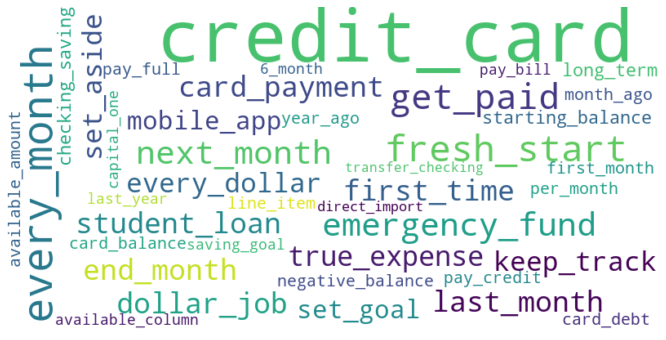

In [42]:
wc = WordCloud(background_color="white", max_words=40, width=800, height=400, collocations=False)

wc.generate(" ".join(ynab.text_ngrams))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [43]:
# wc.to_file("images/text_bigrams.png")

## Time Series

In [44]:
print("Newest post:", ynab.posted.max())
print("Oldest post:", ynab.posted.min())

Newest post: 2020-06-17 12:47:00
Oldest post: 2017-10-26 01:50:00


In [45]:
posts_per_month = ynab.groupby("month").count().reset_index()[["month", "user"]]
posts_per_month

fig = px.line(posts_per_month, x="month", y="user", title="Posts per Month")
fig.show()

monthly_diff = posts_per_month.diff().loc[1:,]
monthly_diff["z_score"] = stats.zscore(monthly_diff.user)
monthly_diff.loc[monthly_diff.z_score > 2]

,month,user,z_score
1,31 days,138.0,2.033493
31,30 days,138.0,2.033493


In [46]:
# fig.write_image("images/posts_per_month.png")

## Bigram WC for April 2020

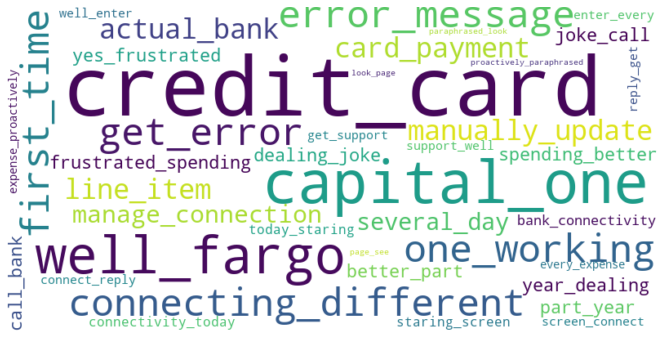

In [47]:
ynab_exp = pd.merge(ynab, category_stats[["category", "p_ratio", "l_ratio",
                                          "r_ratio", "v_ratio", "f_ratio"]], how="outer", on="category")
ynab_exp.loc[ynab_exp.month=="2020-04-01"].groupby("category").sum().sort_values("p_ratio", ascending=False)

wc.generate(' '.join(ynab.loc[(ynab.month=="2020-04-01") & \
                              (ynab.category=="Accounts & Transactions"),:].text_ngrams))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [48]:
# wc.to_file("images/april2020_bigrams.png")